In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from lib.data.datasets import AccRawDataset
from lib.data.dataloading import load_raw
from lib.config import RAW_DIR
from lib.modules import optimization_loop_xonly

In [3]:
WINSIZE = 1001
trainloader, testloader = load_raw(
    RAW_DIR,
    WINSIZE,
    n_hours=12,
    test_size=0.5,
    batch_size=512,
    shuffle_test=True,
    chunk_len_hrs=2
)

Using all available sessions
Using Directories: ['11-07_20_24_32', '2023-10-26_15_32_20', '11-07_17_43_30', '11-08_08_27_30', '11-08_07_17_47', '11-10_08_54_24', '2023-11-11_17_50_20', '2023-11-01_15_47_52', '2023-11-01_15_49_48', '11-07_12_58_43', '2023-11-10_13_11_41', '2023-11-02_13_55_22', '11-01_20_34_28', '10-27_00_21_25', '11-07_17_29_01', '11-01_20_54_52', '11-07_15_03_24', '10-27_09_45_42', '11-02_19_28_19', '10-28_13_18_42', '10-27_00_20_15']
Index: 0, Date: 11-07_20_24_32, nSamples: 30117, Time Elapsed: 0:04:49.392967, Time Recorded: 0:05:01.170000
Index: 1, Date: 2023-10-26_15_32_20, nSamples: 2961601, Time Elapsed: 7:53:59.529118, Time Recorded: 8:13:36.010000
Index: 2, Date: 11-07_17_43_30, nSamples: 1005447, Time Elapsed: 2:41:00.547341, Time Recorded: 2:47:34.470000
Index: 3, Date: 11-08_08_27_30, nSamples: 5125043, Time Elapsed: 1 day, 6:08:45.212074, Time Recorded: 14:14:10.430000
Index: 4, Date: 11-08_07_17_47, nSamples: 338215, Time Elapsed: 0:54:09.386096, Time Rec

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, seq_len):
        super().__init__()
        self.c = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.LayerNorm((out_channels, seq_len)),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.LayerNorm((out_channels, seq_len)),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.LayerNorm((out_channels, seq_len)),
            nn.ReLU()
        )
        self.identity = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.LayerNorm((out_channels, seq_len))
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.identity(x) + self.c(x))

class MaskedAutoEncoder(nn.Module):
    def __init__(self, winsize, in_channels, dims, maskpct=0.25):
        super().__init__()
        self.winsize = winsize
        self.in_channels = in_channels
        self.dims = dims
        self.maskpct = maskpct
        # self.dims = [self.in_channels] + list(dims)

        self.e = nn.Sequential(
            nn.Conv1d(in_channels, dims[0], kernel_size=9, padding='same'),
            nn.LayerNorm((dims[0], winsize)),
            nn.ReLU(),
            *[ResBlock(self.dims[i], self.dims[i+1], 3, 'same', winsize) for i in range(len(self.dims)-1)]
        )

        self.d = nn.Sequential(
            *[ResBlock(self.dims[i], self.dims[i-1], 3, 'same', winsize) for i in range(len(self.dims)-1, 0, -1)],
            nn.Conv1d(self.dims[0], in_channels, kernel_size=9, padding='same'),
        )

    def forward(self, x):
        x = x.view(-1, self.in_channels, self.winsize).clone()
        # Mask: randomly set maskpct% of X (xyz pairs) to values from a normal distribution
        mask = torch.rand(x.shape[0], 1, x.shape[2]) < self.maskpct # maskpct% of values are True
        mask = mask.expand(-1,3,-1)                         # expand to all xyz pairs
        x[mask] = torch.randn(x.shape)[mask].to(x.device)   # set masked values to random normal
        x = self.e(x)
        x = self.d(x)
        return x.flatten(start_dim=1)

In [6]:
DEVICE = 'cuda:1'
model = MaskedAutoEncoder(WINSIZE, 3, (8,16,32,64), 0.25).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [7]:
optimization_loop_xonly(
    model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    epochs=10,
    device=DEVICE,
    outdir='dev/7_mae/dev2'
)

  0%|          | 0/10 [00:00<?, ?it/s]

: Epoch 2: Train Loss: 0.06307: Dev Loss: 0.14579:  30%|███       | 3/10 [56:41<2:12:17, 1133.98s/it]


KeyboardInterrupt: 

In [200]:
for X in trainloader:
    X = X.to(DEVICE)
    logits = model(X)
    print(X.equal(logits))
    print(nn.MSELoss()(X, logits))
    break

tensor([ 0.2005, -0.6049, -1.5401,  ..., -0.8884,  0.2726,  0.2432],
       device='cuda:1')
False
tensor(8.6069, device='cuda:1')


In [175]:
logits[0].shape

torch.Size([3003])

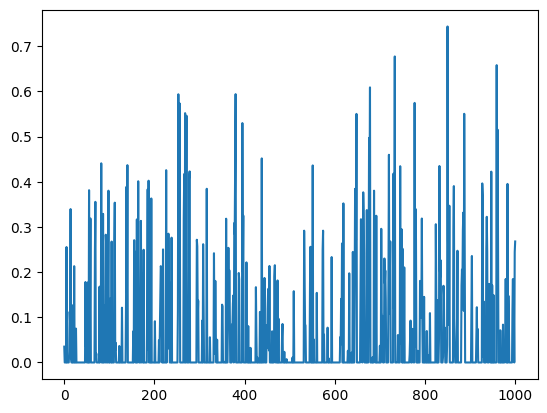

In [153]:
import matplotlib.pyplot as plt

plt.plot(logits[0, 6].cpu().detach())